# TB Dataset Interpretation Notebook

In [2]:
library(Seurat)
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Identify and Extract Expression for Top Variable Genes

In [2]:
# Imports normalized gene expression data
gene_expr = readRDS('/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')

In [ ]:
# Use Seruat to efficiently compute variable genes
seurat<-CreateSeuratObject(counts = gene_expr, 
                           min.cells = 0, min.features = 0, # Maintain QC from previous study
                           project = "TBRU")

In [ ]:
n_var_genes = 5000

In [ ]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = n_var_genes)

In [ ]:
var_genes <- head(VariableFeatures(seurat), n_var_genes)

In [ ]:
write.table(var_genes, "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt", sep = "\t")

## Load Data

In [3]:
### Include only cells retained by CNA
refine_cells <- function(expr_mat, input_res){
    loc_cells = match(input_res$cell_id[which(input_res$keptcells=="True")], colnames(expr_mat))
    input_res = input_res[which(input_res$keptcells=="True"),]
    expr_mat = expr_mat[,loc_cells]
    
    # Confirm cell order matches
    if(sum(input_res$cell_id==colnames(expr_mat))==dim(input_res)[1]){
        return(list(expr_mat, input_res))
    }else{
      return(list(False, False))   
    }
}

In [4]:
### Compute per-gene correlations to information of interest (e.g. NAM PC loadings)
compute_corrs <- function(curr_res, expr_mat, corr_col_name){
    cna_scores = curr_res[corr_col_name]
    corrs_1 = cor(t(as.matrix(expr_mat[1:1000,])), cna_scores)
    corrs_2 = cor(t(as.matrix(expr_mat[1001:2000,])), cna_scores)
    corrs_3 = cor(t(as.matrix(expr_mat[2001:3000,])), cna_scores)
    corrs_4 = cor(t(as.matrix(expr_mat[3001:4000,])), cna_scores)
    corrs_5 = cor(t(as.matrix(expr_mat[4001:5000,])), cna_scores)
    corrs = c(corrs_1, corrs_2, corrs_3, corrs_4, corrs_5)
    names(corrs) = rownames(expr_mat)
    return(corrs)
}

In [5]:
load_data <-function(res_filename, expr_filename, corr_col_name){
    res = read.csv(res_filename)
    expr_mat = readRDS(expr_filename)
    if(length(grep("/exprs_norm",expr_filename))==1){
        var_genes = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_var_genes.txt",sep = "\t")
        var_genes = var_genes$x
        expr_mat = expr_mat[match(var_genes, rownames(expr_mat)),]
    }
    return(refine_cells(expr_mat, res))
}

### Load Gene Expression, NAM PCs, and Supervised Results

In [2]:
# Imports neighborhood loadings per NAM PC, for harmonized CCA data
survey_res = read.csv("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_survey_results.txt")

In [344]:
# Imports neighborhood loadings per NAM PC, for harmonized CCA data
tb_res = read.csv("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_TBres.txt")
age_res = read.csv("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Age_res.txt")

### GSEA

In [6]:
library(fgsea)
library(GSA)

Loading required package: Rcpp



In [7]:
### Parameters and function for loading gene sets
GeneSet_SizeBound_Upper = 500 # Maximum gene set size considered
GeneSet_SizeBound_Lower = 0 # Minimum gene set size considered

# File names
geneset_files = c("/data/srlab/lrumker/MSigDB_Sets/c7.all.v7.0.symbols.gmt.txt", #Immune
"/data/srlab/lrumker/MSigDB_Sets/h.all.v7.0.symbols.gmt.txt", #Hallmark
"/data/srlab/lrumker/MSigDB_Sets/c2.all.v7.0.symbols.gmt.txt") #Cannonical

parseGeneSetGMT <-function(filepath, known_genes, sizeBound_Upper, sizeBound_Lower){
  Gene_Sets_DB = GSA.read.gmt(filepath)
  GeneSet_sizes = sapply(Gene_Sets_DB$genesets,length)
  recognized_genes = matrix(NA, nrow=length(GeneSet_sizes), ncol = max(GeneSet_sizes))
  for(i in c(1:length(GeneSet_sizes))){
    recognized_genes[i,c(1:GeneSet_sizes[i])] = Gene_Sets_DB$genesets[[i]]
  }
  recognized_genes = matrix(is.element(recognized_genes, known_genes), ncol = ncol(recognized_genes))
  GeneSet_sizes = apply(recognized_genes, 1, sum)
  retain_GeneSet = (GeneSet_sizes>=sizeBound_Lower)&(GeneSet_sizes<=sizeBound_Upper)
  Gene_Sets_DB$genesets = Gene_Sets_DB$genesets[retain_GeneSet]
  Gene_Sets_DB$geneset.names = Gene_Sets_DB$geneset.names[retain_GeneSet]
  Gene_Sets_DB$geneset.descriptions = Gene_Sets_DB$geneset.descriptions[retain_GeneSet]
  Gene_Sets_DB$geneset.sizes = GeneSet_sizes[retain_GeneSet]
  return(Gene_Sets_DB)
}

### Differentially-Expressed Genes

In [8]:
library(presto)

characteristic_expr <-function(expr_mat, categories){
    wilcox_res <- wilcoxauc(expr_mat, categories)
    wilcox_res = wilcox_res[which(wilcox_res$padj<0.05),]
    wilcox_res = wilcox_res[which(wilcox_res$group=="True"),]
    wilcox_res_pos = wilcox_res[which(wilcox_res$logFC>0),]
    wilcox_res_neg = wilcox_res[which(wilcox_res$logFC<0),]
    return(wilcox_res_pos[order(wilcox_res_pos$logFC, decreasing = TRUE),c(1,2,3,4,6,8)])
}

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




### Generate Association Table for Genes and Proteins

In [9]:
report_assoc <- function(prot_mat, expr_mat,prot_names, gene_names, ncorrs){
    corrs = c()
    pvals = c()
    print("Testing proteins")
    for(sel_prot in prot_names){
        my_expr = prot_mat[match(sel_prot, rownames(prot_mat)),]
        my_data = data.frame(ncorrs, my_expr)
        colnames(my_data) = c("corrs", "expr")
        new_summary = summary(lm(corrs ~ expr, data = my_data))
        new_p = new_summary$coefficients[2,4]
        new_corr = cor(my_expr, ncorrs)
        corrs = c(corrs, new_corr)
        pvals = c(pvals, new_p)
    }
    print("Testing genes")
    for(sel_gene in gene_names){
        my_expr = expr_mat[match(sel_gene, rownames(expr_mat)),]
        my_data = data.frame(ncorrs, my_expr)
        colnames(my_data) = c("corrs", "expr")
        new_summary = summary(lm(corrs ~ expr, data = my_data))
        new_p = new_summary$coefficients[2,4]
        new_corr = cor(my_expr, ncorrs)
        corrs = c(corrs, new_corr)
        pvals = c(pvals, new_p)
    }
    df = data.frame("Name"= c(prot_names, gene_names), 
                        "Type"= c(rep("Protein", length(prot_names)),
                                               rep("Gene", length(gene_names))),
                        "Correlation"=corrs, "P-value"=pvals)
    df$P.value[which(df$P.value<0.00000001)] = "<1e-8"
    df$Correlation = round(df$Correlation,3)
    return(df)
}

# Unsupervised Analysis Interpretation

### NAM-PCs Corresponding to Sex

#### Higher loadings are more male-like

#### Correspond to more CD8, less CD4

In [ ]:
# Imports neighborhood loadings per NAM PC, for non-harmonized mRNA data
nam_pcs = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_cna_NAM_PCs_mrna.txt")

In [ ]:
# CD8A expression positively correlated with NAM PC2 (with more Male-ness)
rankList[grep("CD8A", names(rankList))]

In [ ]:
# Positively correlated with CD8+ surface protein expression
cor(prot_expr[grep("CD8", rownames(prot_expr)),], cna_scores)

In [ ]:
# CD4 not among top variable genes
rankList[grep("CD4", names(rankList))]

In [ ]:
# Negatively correlated with CD4+ surface protein expression
cor(prot_expr[grep("CD4.1", rownames(prot_expr)),], cna_scores)

### NAM-PCs Corresponding to Innateness

In [46]:
# Imports neighborhood loadings per NAM PC, for harmonized CCA data
nam_pcs = read.csv("/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_cna_NAM_PCs.txt")

In [50]:
corrs = compute_corrs(nam_pcs, expr_mat, "PC1")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”


In [84]:
corrs[order(corrs, decreasing = TRUE)][1:10]

LTB       MAL      TCF7      JUNB      LDHB      IL7R     SOCS3     RCAN3 
0.5451923 0.3487039 0.3371418 0.3153410 0.2933276 0.2896569 0.2743541 0.2714428 
     SELL      PASK 
0.2397074 0.2310192

In [85]:
rankList = corrs

In [137]:
i_file = 1
Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), GeneSet_SizeBound_Upper,
                               GeneSet_SizeBound_Lower)
input_genesets = Gene_Sets_DB$genesets
names(input_genesets) = Gene_Sets_DB$geneset.names

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [142]:
FGSEA_output = fgsea(input_genesets, rankList, nperm=100000, 
                         minSize = 15, maxSize = 500, nproc = 0,
                         gseaParam = 1, BPPARAM = NULL)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
FGSEA_output = FGSEA_output[grep("TCELL", FGSEA_output$pathway),]

Warning message in fgsea(input_genesets, rankList, nperm = 1e+05, minSize = 15, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [143]:
# File 1
FGSEA_output[FGSEA_output$ES<0,]

pathway,padj,ES
<chr>,<dbl>,<dbl>
KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_DN,0.003993159,-0.8835218
GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN,0.003993159,-0.8458679
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_DN,0.003993159,-0.8889315
GSE26495_NAIVE_VS_PD1LOW_CD8_TCELL_DN,0.003993159,-0.9015362
GSE26928_EFF_MEM_VS_CENTR_MEM_CD4_TCELL_UP,0.003993159,-0.8741589
GSE3982_EFF_MEMORY_VS_CENT_MEMORY_CD4_TCELL_UP,0.003993159,-0.9004278
GSE9650_NAIVE_VS_EFF_CD8_TCELL_DN,0.003993159,-0.8480523
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_NRAS_KO_CD4_TCELL_DN,0.003993159,-0.8926853
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_WT_CD4_TCELL_DN,0.003993159,-0.9107126


In [144]:
FGSEA_output[FGSEA_output$ES>0,]

pathway,padj,ES
<chr>,<dbl>,<dbl>
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_UP,0.009266109,0.9202917
GSE11057_NAIVE_CD4_VS_PBMC_CD4_TCELL_UP,0.009363624,0.8740509
GSE22886_NAIVE_VS_MEMORY_TCELL_DN,0.009417431,0.8230305
GSE22886_NAIVE_CD4_TCELL_VS_NKCELL_UP,0.009569625,0.9074823
GSE22886_NAIVE_TCELL_VS_NKCELL_UP,0.009589937,0.8892330
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_WT_CD4_TCELL_UP,0.009782129,0.9360033
GSE26495_NAIVE_VS_PD1LOW_CD8_TCELL_UP,0.010248259,0.9071695
GSE11057_EFF_MEM_VS_CENT_MEM_CD4_TCELL_DN,0.010459894,0.7539209
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_NRAS_KO_CD4_TCELL_UP,0.010459894,0.9098998


# Supervised Analysis Interpretation

### Ancestry Signal Interpretation

In [10]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Ancestry_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [11]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Ancestry_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [12]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”


In [102]:
# Top most correlated genes
round(corrs[order(-corrs)][1:15],2)

LTB       LDHB        MAL       SELL      RCAN3   C1orf162       TCF7 
      0.46       0.27       0.27       0.25       0.25       0.22       0.21 
      JUNB AP002884.1      SOCS3      BIRC3       PLP2      PRKCA       KRT1 
      0.20       0.20       0.20       0.19       0.19       0.19       0.19 
     NOSIP 
      0.18

In [154]:
# Top most anticorrelated genes
round(corrs[order(corrs)][1:15],2)

NKG7   CCL5   GZMH   GZMA   GNLY FGFBP2   CST7  EFHD2   ZEB2   HOPX   CCL4 
 -0.72  -0.70  -0.70  -0.70  -0.61  -0.60  -0.57  -0.48  -0.48  -0.46  -0.46 
  PRF1   PLEK   LYAR   GZMM 
 -0.45  -0.45  -0.43  -0.42

In [155]:
# Depleted cluster proteins
characteristic_expr(prot_mat, curr_res$negcells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
56,CD244/2B4,True,0.9549795,0.76857316,0.8875561,0.000000e+00
37,CD29,True,2.3023259,0.46332625,0.7312275,0.000000e+00
53,CD279/PD-1,True,0.8615330,0.45904091,0.7212270,0.000000e+00
43,CD195/CCR5,True,0.5312441,0.39151206,0.7924898,0.000000e+00
60,TCRab,True,1.7862399,0.36719141,0.6888247,0.000000e+00
47,CD3,True,3.5790077,0.34328479,0.7192659,0.000000e+00
39,CD45RO,True,2.7797108,0.25999805,0.6800949,0.000000e+00
32,CD4.1,True,3.4264982,0.25567158,0.6883414,0.000000e+00
61,CD48/SLAMF2,True,3.4197007,0.10949329,0.5690841,0.000000e+00


In [89]:
# Expanded cluster proteins
characteristic_expr(prot_mat, curr_res$poscells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
59,CD8a,True,2.89554185,2.657599303,0.9469708,0.000000e+00
42,CD194/CCR4,True,1.91700520,0.847629798,0.7529712,0.000000e+00
38,CD62L,True,1.16009020,0.571639551,0.6695996,0.000000e+00
37,CD29,True,2.03982090,0.163189041,0.5662604,8.995956e-71
61,CD48/SLAMF2,True,3.45480784,0.137102199,0.5973245,1.071469e-150
36,CD28.1,True,1.72206318,0.112950939,0.5493210,5.237439e-40
34,CD26,True,1.18732198,0.090672302,0.5514663,2.038265e-43
49,CD127/IL-7R,True,1.20932137,0.077828516,0.5277576,9.895729e-14
48,CD95/Fas,True,1.49144100,0.068048141,0.5466555,5.525537e-36


In [13]:
interp_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD8a", "CD194/CCR4", "CD62L", "CD244/2B4", "CD29","CD4.1"), 
                             gene_names = c("LTB","LDHB","SELL", "NKG7", "CCL5", "GZMH", "GZMA", "GNLY"), 
                             curr_res$ncorrs) 

[1] "Testing proteins"
[1] "Testing genes"


In [14]:
interp_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD8a,Protein,0.042,<1e-8
CD194/CCR4,Protein,0.472,<1e-8
CD62L,Protein,0.245,<1e-8
CD244/2B4,Protein,-0.516,<1e-8
CD29,Protein,-0.210,<1e-8
CD4.1,Protein,-0.111,<1e-8
LTB,Gene,0.457,<1e-8
LDHB,Gene,0.269,<1e-8
SELL,Gene,0.249,<1e-8


In [90]:
rankList = corrs

In [121]:
i_file = 1
Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), GeneSet_SizeBound_Upper,
                               GeneSet_SizeBound_Lower)
input_genesets = Gene_Sets_DB$genesets
names(input_genesets) = Gene_Sets_DB$geneset.names

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [122]:
FGSEA_output = fgsea(input_genesets, rankList, nperm=10000, 
                         minSize = 15, maxSize = 500, nproc = 0,
                         gseaParam = 1, BPPARAM = NULL)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [120]:
# File 3
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>


In [109]:
# File 2
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>


In [123]:
# File 1
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>
KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_DN,0.03059018,-0.8651402
GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN,0.03059018,-0.8489712
GSE11057_EFF_MEM_VS_CENT_MEM_CD4_TCELL_UP,0.03059018,-0.8570270
GSE11057_CD4_CENT_MEM_VS_PBMC_DN,0.03059018,-0.8509932
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_DN,0.03059018,-0.8989995
GSE26495_NAIVE_VS_PD1LOW_CD8_TCELL_DN,0.03059018,-0.9042928
GSE26928_EFF_MEM_VS_CENTR_MEM_CD4_TCELL_UP,0.03059018,-0.8526048
GSE30083_SP3_VS_SP4_THYMOCYTE_DN,0.03059018,-0.8487004
GSE34205_RSV_VS_FLU_INF_INFANT_PBMC_DN,0.03059018,-0.8637285


In [130]:
cluster_counts = table(curr_res[which(curr_res$poscells=="True"),]$cluster)
cluster_counts[order(cluster_counts, decreasing = TRUE)]
# 23: CD8+ central


  23   26    4    8    3   14   12   16   10    0    2    5    1   11    6   22 
5441  164  135  113   95   81   28   12    8    7    7    6    3    3    2    2 
  25   29    9   15   21 
   2    2    1    1    1 

In [131]:
cluster_counts = table(curr_res[which(curr_res$negcells=="True"),]$cluster)
cluster_counts[order(cluster_counts, decreasing = TRUE)]
# 7: CD4+ cytotoxic
# 18: CD4+ CD161+ cytotoxic
# 27: CD4+ CCR5+ cytotoxic


    7    18    27    11     2     9    19    24    10    22    17     5     0 
20560  8854  3896  2882   443   272   106    47    34    34    17    14    13 
   20    21     1    15     3    12    13     8    14    28     4     6    34 
   13    10     8     5     4     4     3     2     2     2     1     1     1 
   43    55 
    1     1 

### TB Progressor Signal Interpretation

In [43]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_TBres.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [44]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_TBres.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [17]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”


In [20]:
# Top most correlated genes
round(corrs[order(-corrs)][1:15],2)

GZMH     NKG7   FGFBP2     GNLY     ZEB2     CCL4     CST7     GZMB 
    0.58     0.55     0.53     0.49     0.43     0.39     0.38     0.37 
    PRF1    EFHD2   ADGRG1     PLEK     GZMA     CCL5 HLA-DPB1 
    0.35     0.34     0.33     0.32     0.31     0.30     0.30

In [21]:
# Top most anticorrelated genes
round(corrs[order(corrs)][1:15],2)

LTB  AQP3  IL7R KLRB1  CD27   MAL  JUNB  TCF7  BCL2 RCAN3  CCR6  LDHB LIMS1 
-0.47 -0.26 -0.25 -0.23 -0.21 -0.21 -0.19 -0.18 -0.18 -0.17 -0.17 -0.17 -0.16 
NOSIP RPS3A 
-0.16 -0.16

In [22]:
interp_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD26","CD196/CCR6","CD127/IL-7R", "CD244/2B4", "CD279/PD-1", "CD29"),
                             gene_names = c("LTB","AQP3","IL7R","KLRB1","CD27","MAL","GZMH","NKG7","FGFBP2","GNLY","ZEB2","CCL4"), 
                             curr_res$ncorrs) 

[1] "Testing proteins"
[1] "Testing genes"


In [23]:
interp_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD26,Protein,-0.385,<1e-8
CD196/CCR6,Protein,-0.409,<1e-8
CD127/IL-7R,Protein,-0.280,<1e-8
CD244/2B4,Protein,0.436,<1e-8
CD279/PD-1,Protein,0.203,<1e-8
CD29,Protein,0.140,<1e-8
LTB,Gene,-0.469,<1e-8
AQP3,Gene,-0.263,<1e-8
IL7R,Gene,-0.251,<1e-8


In [771]:
# TB progression: depleted cluster proteins
characteristic_expr(prot_mat, curr_res$negcells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
34,CD26,True,1.89524404,0.9523114127,0.7764610,0.000000e+00
44,CD196/CCR6,True,0.61033000,0.3868521183,0.7520726,0.000000e+00
49,CD127/IL-7R,True,1.45537728,0.3855329365,0.6872005,0.000000e+00
50,CD161,True,0.44922371,0.2765633656,0.7254231,0.000000e+00
35,CD27.1,True,1.92646115,0.2239896821,0.5543602,0.000000e+00
41,CD183/CXCR3,True,0.49695020,0.1657462635,0.6128851,0.000000e+00
36,CD28.1,True,1.72384139,0.1351230521,0.5514131,0.000000e+00
32,CD4.1,True,3.30233185,0.1307446261,0.4904725,1.261857e-15
37,CD29,True,1.93682363,0.0691338717,0.5431493,9.027710e-288


In [772]:
# TB progression: expanded cluster proteins
characteristic_expr(prot_mat, curr_res$poscells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
56,CD244/2B4,True,1.0763089,0.875425387,0.9138876,0.000000e+00
53,CD279/PD-1,True,0.9224051,0.510537506,0.7399762,0.000000e+00
37,CD29,True,2.3581230,0.509305458,0.7548168,0.000000e+00
60,TCRab,True,1.8765634,0.452632610,0.7303083,0.000000e+00
47,CD3,True,3.6571005,0.416413926,0.7647040,0.000000e+00
39,CD45RO,True,2.8211140,0.296526350,0.7045581,0.000000e+00
43,CD195/CCR5,True,0.4476590,0.291412088,0.7463157,0.000000e+00
32,CD4.1,True,3.4154787,0.236605984,0.6981690,0.000000e+00
59,CD8a,True,0.4432230,0.178196086,0.6418232,0.000000e+00


In [773]:
# TB progression:  expanded cluster genes
neg_char_genes = characteristic_expr(expr_mat, curr_res$poscells)
neg_char_genes[1:15,]

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5002,NKG7,True,3.442986,3.1945678,0.9728386,0
5004,GZMH,True,2.858419,2.7504632,0.9770452,0
5001,CCL5,True,3.319225,2.6945411,0.9379611,0
5003,GNLY,True,2.811847,2.6680513,0.8898776,0
5012,FGFBP2,True,1.944219,1.8912164,0.9282497,0
5006,GZMA,True,2.206890,1.8622076,0.9049089,0
5024,CST7,True,1.761156,1.4803180,0.8878809,0
5195,EFHD2,True,1.600390,1.3055896,0.8732290,0
5014,S100A4,True,3.511100,1.0620969,0.8302447,0


In [774]:
# TB progression:  depleted cluster genes
pos_char_genes = characteristic_expr(expr_mat, curr_res$negcells)
pos_char_genes[1:15,]

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5010,KLRB1,True,1.5316003,1.0275894,0.7526262,0
5009,LTB,True,3.0110847,0.5986247,0.6651218,0
5020,IL7R,True,2.4540626,0.5407064,0.6563239,0
5052,NFKBIA,True,1.9667621,0.3775157,0.6121957,0
5005,GZMK,True,0.6364761,0.3694946,0.5870613,0
5265,EEF1B2,True,2.9406961,0.3625982,0.6304955,0
5106,RPS12,True,4.5569790,0.3126650,0.6164930,0
6254,AQP3,True,0.8189573,0.3104060,0.6115431,0
5110,LYAR,True,0.6975944,0.3034068,0.5991164,0


In [775]:
rankList = corrs

In [782]:
i_file = 3
Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), GeneSet_SizeBound_Upper,
                               GeneSet_SizeBound_Lower)
input_genesets = Gene_Sets_DB$genesets
names(input_genesets) = Gene_Sets_DB$geneset.names

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [783]:
FGSEA_output = fgsea(input_genesets, rankList, nperm=10000, 
                         minSize = 15, maxSize = 500, nproc = 0,
                         gseaParam = 1, BPPARAM = NULL)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [778]:
# File 1
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>
KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_DN,0.02356688,0.8237280
GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN,0.02356688,0.8247818
GSE11057_CD4_CENT_MEM_VS_PBMC_DN,0.02356688,0.8361995
GSE13229_IMM_VS_MATURE_NKCELL_DN,0.02356688,0.8575306
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_DN,0.02356688,0.8640408
GSE26495_NAIVE_VS_PD1LOW_CD8_TCELL_DN,0.02356688,0.8883697
GSE26495_PD1HIGH_VS_PD1LOW_CD8_TCELL_DN,0.02356688,0.8371689
GSE26928_EFF_MEM_VS_CENTR_MEM_CD4_TCELL_UP,0.02356688,0.8579516
GSE29618_BCELL_VS_MDC_DN,0.02356688,0.8223162


In [781]:
# File 2
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>


In [784]:
# File 3
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>
REACTOME_HEMOSTASIS,0.02790675,0.7482627
REACTOME_ADAPTIVE_IMMUNE_SYSTEM,0.02790675,0.7290092
SCHUETZ_BREAST_CANCER_DUCTAL_INVASIVE_UP,0.02790675,0.7756466
MULLIGHAN_MLL_SIGNATURE_1_UP,0.02790675,0.7954693
RICKMAN_METASTASIS_DN,0.02790675,0.8202156
MARTENS_TRETINOIN_RESPONSE_UP,0.02790675,0.7475244
CHICAS_RB1_TARGETS_CONFLUENT,0.02790675,0.7344563
KEGG_RIBOSOME,0.03604191,-0.9644820
KEGG_CELL_ADHESION_MOLECULES_CAMS,0.03604191,0.8315918


### Winter Signal Interpretation

In [24]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Winter_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [25]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Winter_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [26]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”


In [201]:
# Top most correlated genes
round(corrs[order(-corrs)][1:15],2)

GATA3       KRT1      ANXA1       IL7R       NEFL    ZFP36L2 AP002884.1 
      0.28       0.26       0.26       0.25       0.24       0.24       0.21 
   TNFAIP3      TIMP1   C1orf162       TOB1        VIM        FRY       PLP2 
      0.20       0.19       0.19       0.17       0.16       0.16       0.15 
      LMNA 
      0.14

In [202]:
# Top most anticorrelated genes
round(corrs[order(corrs)][1:15],2)

LIMS1   TIGIT    CD27  TBC1D4   CTLA4     LBH    PASK HLA-DRA   ITGA4    FYB1 
  -0.27   -0.27   -0.25   -0.19   -0.18   -0.17   -0.16   -0.16   -0.16   -0.16 
  IKZF3     FYN    CD3D    GBP5   ITM2A 
  -0.15   -0.15   -0.15   -0.14   -0.14

In [27]:
interp_report = report_assoc(prot_mat, expr_mat,
                             prot_names = c("CD183/CXCR3", "CD194/CCR4"),
                             gene_names = c("GATA3","KRT1","ANXA1","IL7R", "STAT1", "IFNG", "LIMS1","TIGIT", "CD27", "TBC1D4", "CTLA4"),
                             curr_res$ncorrs) 

[1] "Testing proteins"
[1] "Testing genes"


In [28]:
interp_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD183/CXCR3,Protein,-0.114,<1e-8
CD194/CCR4,Protein,0.278,<1e-8
GATA3,Gene,0.278,<1e-8
KRT1,Gene,0.263,<1e-8
ANXA1,Gene,0.263,<1e-8
IL7R,Gene,0.252,<1e-8
STAT1,Gene,-0.040,<1e-8
IFNG,Gene,-0.079,<1e-8
LIMS1,Gene,-0.274,<1e-8


In [708]:
check_genes = c("TLR4", "IL1B", "IL6", "TNF", "IFNG", "IL10")
for(i_gene in c(1:length(check_genes))){
    print(corrs[grep(check_genes[i_gene], names(corrs))])
}

named numeric(0)
named numeric(0)
      IL6ST        IL6R 
-0.07269734 -0.05990872 
       TNFAIP3        TNFSF18        C1QTNF2            TNF      TNFRSF13B 
  0.2012228603   0.0020055862  -0.0003365376   0.0336111868  -0.0376612377 
      TNFRSF17        TNFRSF9 RTEL1-TNFRSF6B       C1QTNF9B        TNFAIP6 
  0.0002657027  -0.0483914838  -0.0015249528  -0.0023943095  -0.0032250377 
        TNFSF9       TNFRSF1B        TNFRSF4       TNFRSF25      TNFRSF10A 
  0.0002242700  -0.0882001819   0.0989915877   0.0110476283  -0.0070629972 
       C1QTNF4       C1QTNF12        C1QTNF3 
 -0.0009752118  -0.0003153791  -0.0038206263 
       IFNG    IFNG-AS1 
-0.07929856 -0.02107055 
        IL10       IL10RA 
-0.026404517 -0.003967104 


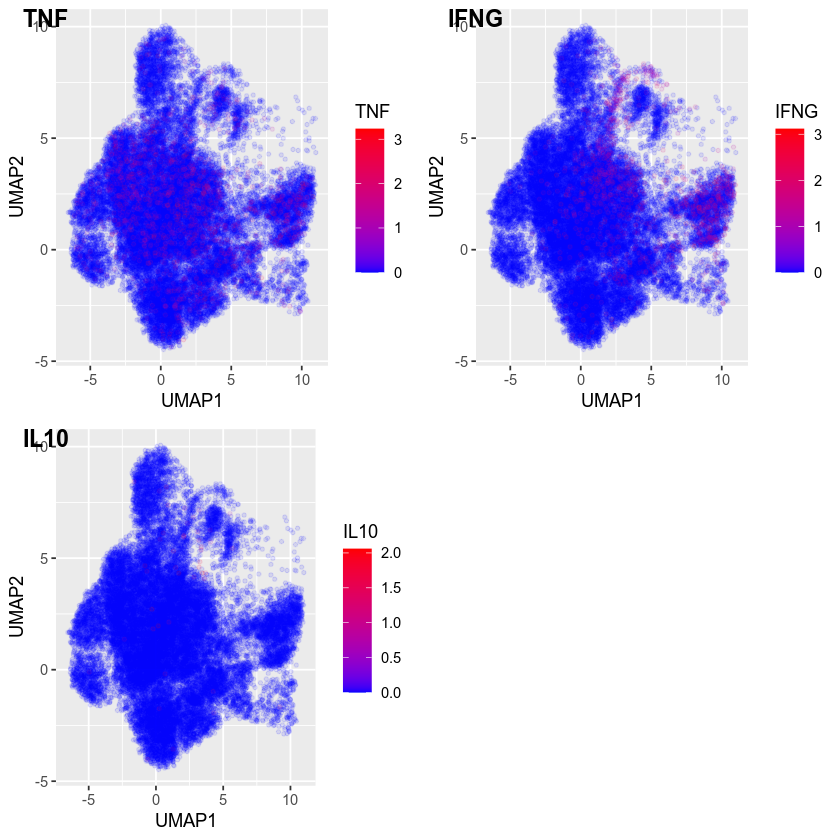

In [715]:
# Organize data to plot
ix = sample(c(1:ncol(prot_mat)), 30000, replace=FALSE) # Downsample
plot_df = data.frame("UMAP1" = curr_res$UMAP1[ix], "UMAP2"= curr_res$UMAP2[ix],
                     "TNF" = expr_mat[match("TNF", rownames(expr_mat)),ix], 
                     "IFNG"= expr_mat[match("IFNG", rownames(expr_mat)),ix], 
                     "IL10" = expr_mat[match("IL10", rownames(expr_mat)),ix])

# TNF
plot_df = plot_df[order(plot_df$TNF),]
TNF_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=TNF)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# IFNG
plot_df = plot_df[order(plot_df$IFNG),]
IFNG_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=IFNG)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# IL10
plot_df = plot_df[order(plot_df$IL10),]
IL10_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=IL10)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

figure <- ggarrange(TNF_plot, IFNG_plot, IL10_plot,
                    labels = c("TNF", "IFNG", "IL10"),
                    ncol = 2, nrow = 2)
figure

In [47]:
# Winter: depleted cluster proteins
characteristic_expr(prot_mat, curr_res$negcells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
35,CD27.1,True,2.27914497,0.604093023,0.6711495,0.000000e+00
52,CD38.1,True,0.73214785,0.515437106,0.7416411,0.000000e+00
55,CD278/ICOS,True,1.52354018,0.369978930,0.6769379,0.000000e+00
36,CD28.1,True,1.82137616,0.235574433,0.6250315,0.000000e+00
53,CD279/PD-1,True,0.64893058,0.231325833,0.6343931,0.000000e+00
48,CD95/Fas,True,1.59210525,0.187584114,0.6045220,0.000000e+00
50,CD161,True,0.33596080,0.132272769,0.6149795,0.000000e+00
54,TIGIT.1,True,0.18513264,0.109253360,0.6580317,0.000000e+00
32,CD4.1,True,3.27352967,0.090199816,0.4585055,2.588233e-185


In [48]:
# Winter:  expanded cluster proteins
characteristic_expr(prot_mat, curr_res$poscells)

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
42,CD194/CCR4,True,1.763662135,0.7222752864,0.7198084,0.000000e+00
34,CD26,True,1.525271403,0.4523842677,0.6682831,0.000000e+00
49,CD127/IL-7R,True,1.425134842,0.3096858716,0.6490785,0.000000e+00
38,CD62L,True,0.865762657,0.2849980264,0.5869022,0.000000e+00
61,CD48/SLAMF2,True,3.507153399,0.1984964983,0.6434572,0.000000e+00
37,CD29,True,2.065995690,0.1980166960,0.5863332,0.000000e+00
33,CD25,True,0.415731894,0.1883079016,0.7040061,0.000000e+00
48,CD95/Fas,True,1.598069757,0.1838948392,0.6211708,0.000000e+00
36,CD28.1,True,1.724323071,0.1202705166,0.5499287,8.259146e-149


In [49]:
# Winter:  expanded cluster genes
neg_char_genes = characteristic_expr(expr_mat, curr_res$negcells)
neg_char_genes[1:15,]

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5987,LIMS1,True,1.0527903,0.5846483,0.6974056,0
5010,KLRB1,True,1.1912534,0.5814743,0.6452090,0
5739,FYB1,True,1.9829436,0.4120743,0.6452794,0
6666,CD27,True,0.8668160,0.3918787,0.6418632,0
6026,TIGIT,True,0.4555210,0.3354137,0.6273289,0
5947,PASK,True,0.6135984,0.3307471,0.6187474,0
5567,COTL1,True,1.4202414,0.3175190,0.6043805,0
6254,AQP3,True,0.8344425,0.3079290,0.6067054,0
5174,LDHB,True,1.9043174,0.3021876,0.5974043,0


In [731]:
check_genes = c("STAT1", "SLEB11", # STAT4
                "TBET", "IL2", "IFNG", "TNFA", "TNFB")
for(i_gene in c(1:length(check_genes))){
    print(check_genes[i_gene])
    found_gene = match(check_genes[i_gene], neg_char_genes$feature)
    if(is.na(found_gene)){
        in_top_5000 = match(check_genes[i_gene], rownames(expr_mat))
        if(is.na(in_top_5000)){
            print("In top 5000 variable genes, but not characteristic.")
        }else{
            print("Not in top 5000 variable genes.")
        }
    }else{
       print(neg_char_genes[found_gene,]) 
    } 
}

[1] "STAT1"
     feature group   avgExpr      logFC       auc          padj
6049   STAT1  True 0.3596326 0.05371176 0.5243287 5.231657e-114
[1] "SLEB11"
[1] "In top 5000 variable genes, but not characteristic."
[1] "TBET"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL2"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IFNG"
     feature group   avgExpr      logFC       auc         padj
5869    IFNG  True 0.0542406 0.00860666 0.5065513 2.730057e-44
[1] "TNFA"
[1] "In top 5000 variable genes, but not characteristic."
[1] "TNFB"
[1] "In top 5000 variable genes, but not characteristic."


In [733]:
# Winter:  expanded cluster genes
# GATA3 is TF for Th2 cells: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3688666/
# LGALS1 in activated/effector T cells:  https://pubmed.ncbi.nlm.nih.gov/9710209/
# NEFL: also seems to by CD4+ Th2 characteristic https://www.proteinatlas.org/ENSG00000277586-NEFL/tissue/T-cells
pos_char_genes = characteristic_expr(expr_mat, curr_res$poscells)
pos_char_genes[1:15,]

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5573,GATA3,True,1.0652607,0.6593077,0.7136907,0.000000e+00
5016,LGALS1,True,1.0342703,0.3327814,0.5978707,0.000000e+00
6238,NEFL,True,0.3664237,0.3134443,0.6235936,0.000000e+00
5009,LTB,True,2.7866991,0.2930290,0.5701657,1.312205e-290
5014,S100A4,True,2.7869408,0.2912413,0.5848954,0.000000e+00
6692,C1orf162,True,0.6015487,0.2850236,0.6077899,0.000000e+00
7896,FXYD5,True,1.6281396,0.2817137,0.6055290,0.000000e+00
5435,KRT1,True,0.3359596,0.2739104,0.6017312,0.000000e+00
8276,TIMP1,True,0.7218043,0.2723918,0.6017282,0.000000e+00


In [738]:
check_genes = c("GATA3", "LSIRF", # IRF4
                "STAT5", "STAT6", "IL4", "IL5", "IL9", "CSIF", #IL10
                "IL13", "IL21")
for(i_gene in c(1:length(check_genes))){
    print(check_genes[i_gene])
    found_gene = match(check_genes[i_gene], pos_char_genes$feature)
    if(is.na(found_gene)){
        in_top_5000 = match(check_genes[i_gene], rownames(expr_mat))
        if(is.na(in_top_5000)){
            print("In top 5000 variable genes, but not characteristic.")
        }else{
            print("Not in top 5000 variable genes.")
        }
    }else{
       print(pos_char_genes[found_gene,]) 
    } 
}

[1] "GATA3"
     feature group  avgExpr     logFC       auc padj
5573   GATA3  True 1.065261 0.6593077 0.7136907    0
[1] "LSIRF"
[1] "In top 5000 variable genes, but not characteristic."
[1] "STAT5"
[1] "In top 5000 variable genes, but not characteristic."
[1] "STAT6"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL4"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL5"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL9"
[1] "In top 5000 variable genes, but not characteristic."
[1] "CSIF"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL13"
[1] "In top 5000 variable genes, but not characteristic."
[1] "IL21"
[1] "In top 5000 variable genes, but not characteristic."


In [208]:
rankList = corrs

In [223]:
i_file = 3
Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), GeneSet_SizeBound_Upper,
                               GeneSet_SizeBound_Lower)
input_genesets = Gene_Sets_DB$genesets
names(input_genesets) = Gene_Sets_DB$geneset.names

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [224]:
FGSEA_output = fgsea(input_genesets, rankList, nperm=10000, 
                         minSize = 15, maxSize = 500, nproc = 0,
                         gseaParam = 1, BPPARAM = NULL)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (0.3% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [222]:
# File 2
FGSEA_output

pathway,padj,ES
<chr>,<dbl>,<dbl>
HALLMARK_E2F_TARGETS,0.01427816,-0.8081728
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.01427816,0.7020020
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.01526718,0.6339607


In [226]:
# File 3
FGSEA_output[grep("REACTOME", FGSEA_output$pathway),]

pathway,padj,ES
<chr>,<dbl>,<dbl>
REACTOME_TRANSLATION,0.03061991,0.8029344
REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE,0.03061991,0.9198596
REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION,0.03061991,-0.8708517
REACTOME_SELENOAMINO_ACID_METABOLISM,0.03061991,0.8942685
REACTOME_RRNA_PROCESSING,0.03061991,0.8682832
REACTOME_EUKARYOTIC_TRANSLATION_INITIATION,0.03061991,0.8115407
REACTOME_RRNA_PROCESSING_IN_THE_NUCLEUS_AND_CYTOSOL,0.03061991,0.8682832
REACTOME_NONSENSE_MEDIATED_DECAY_NMD,0.03061991,0.8507477
REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDENT_OF_THE_EXON_JUNCTION_COMPLEX_EJC,0.03061991,0.9198596


In [79]:
names(input_genesets)[grep("TNFA", names(input_genesets))]

[1] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"

In [81]:
write.table(input_genesets[grep("INTERFERON_ALPHA", names(input_genesets))],
           file =  "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_IFN_alpha_geneset.txt",
           row.names=FALSE)

In [82]:
write.table(input_genesets[grep("INTERFERON_GAMMA", names(input_genesets))],
           file =  "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_IFN_gamma_geneset.txt",
           row.names=FALSE)

In [ ]:
write.table(input_genesets[grep("TNFA", names(input_genesets))],
           file =  "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_TNFA_geneset.txt",
           row.names=FALSE)

In [80]:
write.table(input_genesets[grep("REACTOME_INTERFERON_SIGNALING", names(input_genesets))],
           file =  "/data/srlab/lrumker/MCSC_Project/TBRU_dset_extras/TBRU_IFN_geneset.txt",
           row.names=FALSE)

In [764]:
# File 3
FGSEA_output[grep("REACTOME_INTERFERON_SIGNALING", FGSEA_output$pathway),]

pathway,padj,ES
<chr>,<dbl>,<dbl>
REACTOME_INTERFERON_SIGNALING,0.007671102,0.3283227


In [753]:
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
FGSEA_output #[grep("TCELL", FGSEA_output$pathway),]

pathway,padj,ES
<chr>,<dbl>,<dbl>
HALLMARK_MITOTIC_SPINDLE,0.0006411431,0.3992281
HALLMARK_G2M_CHECKPOINT,0.0006411431,0.4582150
HALLMARK_APOPTOSIS,0.0006411431,0.4835622
HALLMARK_INTERFERON_ALPHA_RESPONSE,0.0006411431,0.5182211
HALLMARK_INTERFERON_GAMMA_RESPONSE,0.0006411431,0.3643067
HALLMARK_E2F_TARGETS,0.0006411431,0.6153338
HALLMARK_UV_RESPONSE_DN,0.0016495601,0.4727896
HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.0017277552,0.3951817
HALLMARK_ESTROGEN_RESPONSE_EARLY,0.0017277552,0.4842488


In [697]:
# Assign CD4+ and CD8+ populations
CD4 = prot_mat[grep("CD4.1", rownames(prot_mat)),]
CD8 = prot_mat[grep("CD8a", rownames(prot_mat)),]

# Set gating thresholds for CD4+ and CD8+ cell populations
CD4_low = CD4<1.5
CD4_high = CD4>=1.5
CD8_low = CD8<1
CD8_high = CD8>=1

# Add CD4 and CD8 assignments to current data object
curr_res$CD4 = CD4_high&CD8_low
curr_res$CD8 = CD4_low&CD8_high

In [702]:
# What fractions of our total T cell dataset belong to each CD4/CD8 categorization?
fractions = matrix(c(sum(CD4_low&CD8_high)/length(CD4), sum(CD4_low&CD8_low)/length(CD4),
         sum(CD4_high&CD8_high)/length(CD4), sum(CD4_high&CD8_low)/length(CD4)),nrow = 2)
round(fractions,3)*100

4.5,1.3
1.2,93.0


In [718]:
sum(curr_res$poscells=="True")/length(curr_res$poscells)

[1] 0.05536491

In [719]:
sum(curr_res$negcells=="True")/length(curr_res$poscells)

[1] 0.1057398

In [698]:
# What fraction of expanded with higher age cells are CD4+?
sum(curr_res$CD4&curr_res$poscells=="True")/sum(curr_res$poscells=="True")

[1] 0.9508156

In [699]:
# What fraction of expanded with higher age cells are CD8+?
sum(curr_res$CD8&curr_res$poscells=="True")/sum(curr_res$poscells=="True")

[1] 0.0320368

In [700]:
# What fraction of depleted with higher age cells are CD4+?
sum(curr_res$CD4&curr_res$negcells=="True")/sum(curr_res$negcells=="True")

[1] 0.9865324

In [701]:
# What fraction of depleted with higher age cells are CD8+?
sum(curr_res$CD8&curr_res$negcells=="True")/sum(curr_res$negcells=="True")

[1] 0.006481988

In [671]:
rankList = corrs

In [692]:
i_file = 3
Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), GeneSet_SizeBound_Upper,
                               GeneSet_SizeBound_Lower)
input_genesets = Gene_Sets_DB$genesets
names(input_genesets) = Gene_Sets_DB$geneset.names

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [673]:
rankList = rankList[which(!is.na(rankList))]

In [693]:
FGSEA_output = fgsea(input_genesets, rankList, nperm=10000, 
                         minSize = 15, maxSize = 500, nproc = 0,
                         gseaParam = 1, BPPARAM = NULL)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]


In [696]:
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),]
FGSEA_output[grep("REACTOME", FGSEA_output$pathway),c(1,3,4)]

pathway,padj,ES
<chr>,<dbl>,<dbl>
REACTOME_SRP_DEPENDENT_COTRANSLATIONAL_PROTEIN_TARGETING_TO_MEMBRANE,0.02951006,0.9198596
REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION,0.02951006,-0.8708517
REACTOME_SELENOAMINO_ACID_METABOLISM,0.02951006,0.8942685
REACTOME_RRNA_PROCESSING,0.02951006,0.8682832
REACTOME_RRNA_PROCESSING_IN_THE_NUCLEUS_AND_CYTOSOL,0.02951006,0.8682832
REACTOME_NONSENSE_MEDIATED_DECAY_NMD_INDEPENDENT_OF_THE_EXON_JUNCTION_COMPLEX_EJC,0.02951006,0.9198596
REACTOME_INTERFERON_GAMMA_SIGNALING,0.03650117,-0.8324185
REACTOME_NONSENSE_MEDIATED_DECAY_NMD,0.03650117,0.8507477
REACTOME_COSTIMULATION_BY_THE_CD28_FAMILY,0.04547627,-0.8268730


In [683]:
# No significantly enriched genesets for
min(FGSEA_output$padj)

[1] 0.184323

# Age Interpretation

### Age signal interpretation

In [30]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Age_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/exprs_norm_01.12.rds')
expr_mat = list_out[[1]]
curr_res = list_out[[2]]

In [31]:
list_out = load_data("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/tbru_cna_Age_res.txt",
                    '/data/srlab1/anathan/TBRU/data/analysis/adt_exprs_norm_01.12.rds')
prot_mat = list_out[[1]]
curr_res = list_out[[2]]

In [32]:
corrs = compute_corrs(curr_res, expr_mat, "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[2001:3000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[4001:5000, ])), cna_scores):
“the standard deviation is zero”


In [230]:
# Top most correlated genes
round(corrs[order(-corrs)][1:15],2)

GZMH     NKG7   FGFBP2     GNLY     GZMA     CST7     ZEB2     CCL5 
    0.54     0.50     0.47     0.45     0.38     0.38     0.37     0.36 
    CCL4 HLA-DPB1     PLEK    EFHD2     GZMB     PRF1   ADGRG1 
    0.34     0.32     0.32     0.32     0.32     0.32     0.30

In [231]:
# Top most anticorrelated genes
round(corrs[order(corrs)][1:15],2)

KLRB1     LTB    AQP3   LIMS1    LDHB    TCF7    CCR6    CD27   RPLP1   RCAN3 
  -0.41   -0.41   -0.26   -0.24   -0.18   -0.18   -0.16   -0.15   -0.15   -0.15 
  NOSIP     MAL    IL7R RNASET2  NAP1L1 
  -0.15   -0.15   -0.15   -0.14   -0.13

In [33]:
interp_report = report_assoc(prot_mat, expr_mat,
                            gene_names = c("GZMH", "NKG7", "FGFBP2", "GNLY", "CST7", "GZMA", "CCL5", "CCL4",
                                          "KLRB1", "LTB",  "LDHB", "TCF7", "CCR6", "CD27"),
                             prot_names = c("CD8a","CD4.1","CD27.1","CD28.1"),
                             curr_res$ncorrs) 

[1] "Testing proteins"
[1] "Testing genes"


In [34]:
interp_report

Name,Type,Correlation,P.value
<fct>,<fct>,<dbl>,<chr>
CD8a,Protein,0.252,<1e-8
CD4.1,Protein,-0.092,<1e-8
CD27.1,Protein,-0.343,<1e-8
CD28.1,Protein,-0.386,<1e-8
GZMH,Gene,0.538,<1e-8
NKG7,Gene,0.496,<1e-8
FGFBP2,Gene,0.471,<1e-8
GNLY,Gene,0.450,<1e-8
CST7,Gene,0.381,<1e-8


In [41]:
# Identify correlation for TBET
corrs[match(c("TBX21","STAT4", "STAT3", "EOMES", "SELL"), names(corrs))]

TBX21       STAT4       STAT3       EOMES        SELL 
 0.19869258  0.05808395 -0.03173747  0.10423671 -0.01616882

In [443]:
# Enriched pathways with ncorrs
FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),]
FGSEA_output[grep("TCELL", FGSEA_output$pathway),c(1,3)]

pathway,padj
<chr>,<dbl>
GSE26495_NAIVE_VS_PD1HIGH_CD8_TCELL_DN,0.009647708
GSE26495_NAIVE_VS_PD1LOW_CD8_TCELL_DN,0.009647708
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_NRAS_KO_CD4_TCELL_DN,0.009647708
GSE45739_UNSTIM_VS_ACD3_ACD28_STIM_WT_CD4_TCELL_DN,0.009647708
GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN,0.014344165
KAECH_NAIVE_VS_DAY15_EFF_CD8_TCELL_DN,0.015695503
GSE22886_NAIVE_TCELL_VS_NKCELL_UP,0.015695503
GSE22886_NAIVE_VS_MEMORY_TCELL_DN,0.015695503
GSE22886_NAIVE_CD4_TCELL_VS_NKCELL_UP,0.015695503


### Assign CD4+ and CD8+ Cell populations

In [540]:
CD4 = prot_mat[grep("CD4.1", rownames(prot_mat)),]
CD8 = prot_mat[grep("CD8a", rownames(prot_mat)),]
to_plot = data.frame("CD4" = CD4, "CD8" = CD8)

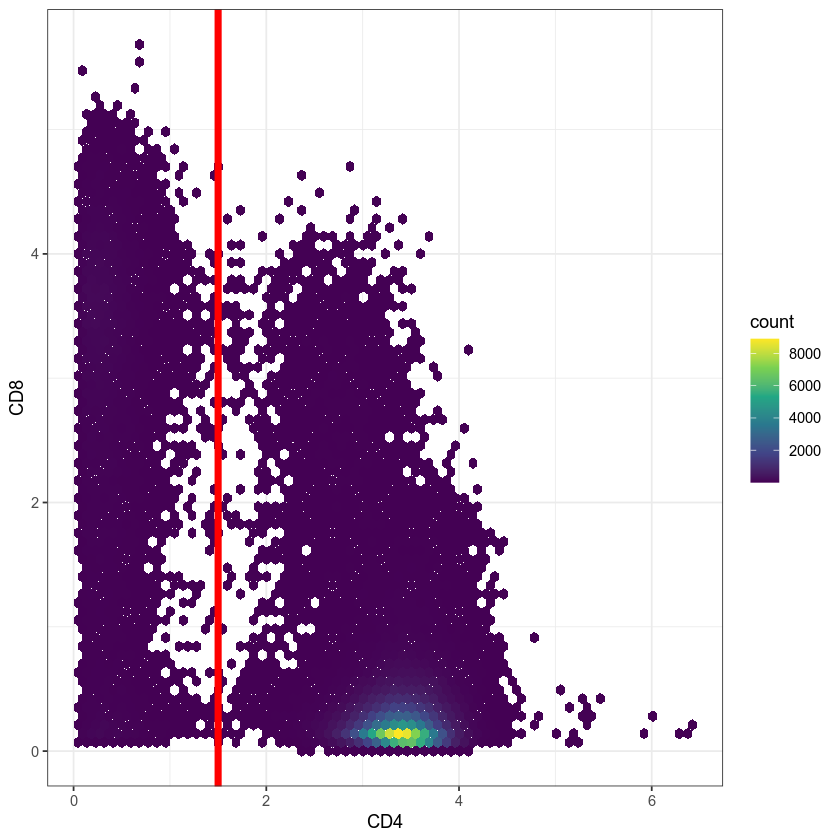

In [570]:
# Find low vs high CD4
some_expr = which((CD8>0)&(CD4>0))
ggplot(to_plot[some_expr,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_vline(xintercept=1.5, color = "red", size=2)

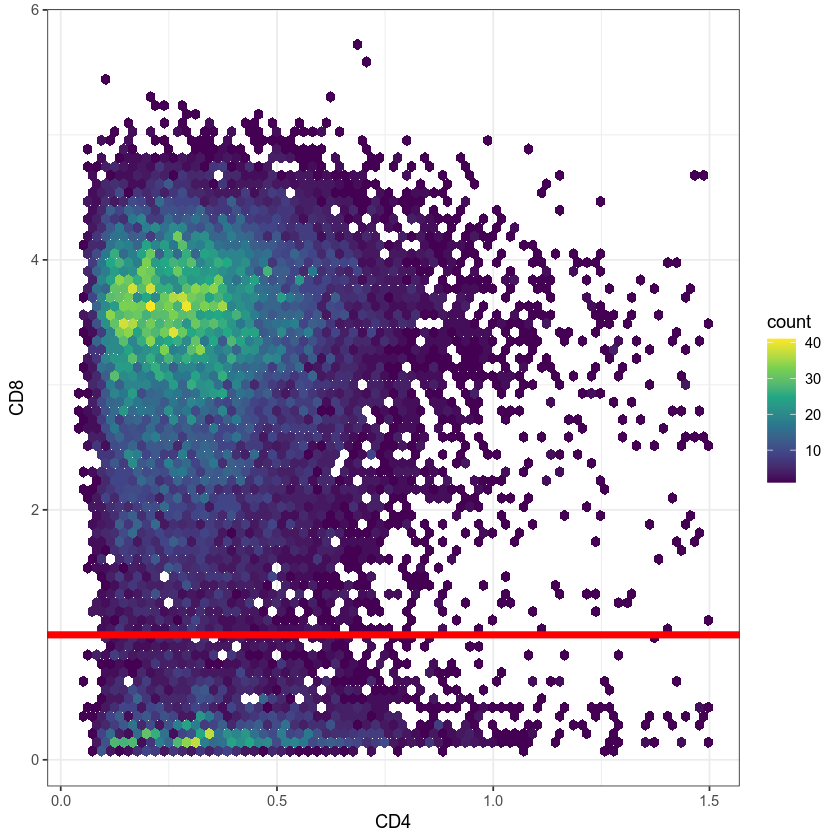

In [561]:
# Find low vs high CD8 gene expression
i_lowCD4 = which(((CD4<1.5)&(CD4>0))&(CD8>0))
ggplot(to_plot[i_lowCD4,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_hline(yintercept=1, color = "red", size=2)

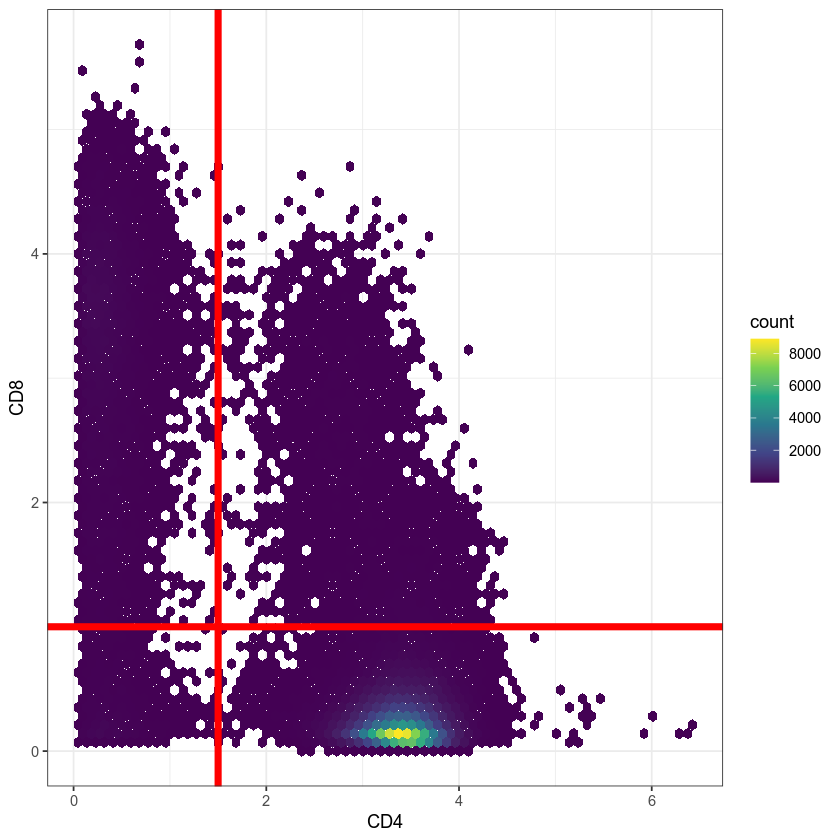

In [577]:
# Find low vs high CD4
ggplot(to_plot[some_expr,], aes(x=CD4, y=CD8) ) +
  geom_hex(bins = 70) +
  scale_fill_continuous(type = "viridis") +
  theme_bw()+
    geom_vline(xintercept=1.5, color = "red", size=2)+
    geom_hline(yintercept=1, color = "red", size=2)

In [578]:
# Set gating thresholds for CD4+ and CD8+ cell populations
CD4_low = CD4<1.5
CD4_high = CD4>=1.5
CD8_low = CD8<1
CD8_high = CD8>=1

# Add CD4 and CD8 assignments to current data object
curr_res$CD4 = CD4_high&CD8_low
curr_res$CD8 = CD4_low&CD8_high

In [596]:
# What fractions of our total T cell dataset belong to each CD4/CD8 categorization?
fractions = matrix(c(sum(CD4_low&CD8_high)/length(CD4), sum(CD4_low&CD8_low)/length(CD4),
         sum(CD4_high&CD8_high)/length(CD4), sum(CD4_high&CD8_low)/length(CD4)),nrow = 2)
round(fractions,3)*100

4.5,1.3
1.2,93.0


### Marker Gene Distributions for Reference

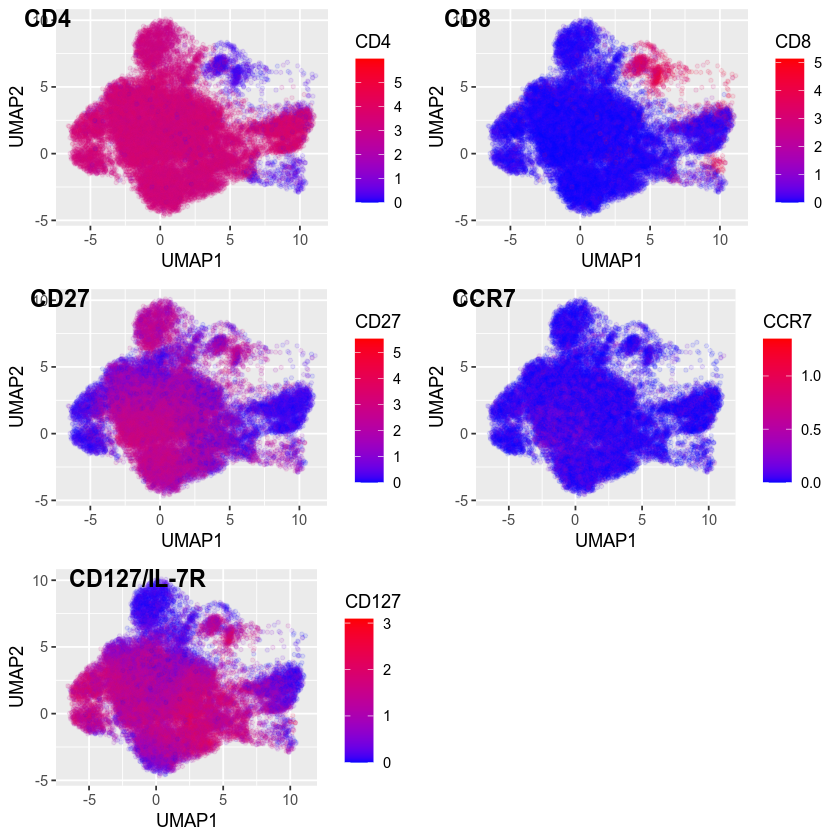

In [651]:
# Organize data to plot
ix = sample(c(1:ncol(prot_mat)), 30000, replace=FALSE) # Downsample
plot_df = data.frame("UMAP1" = curr_res$UMAP1[ix], "UMAP2"= curr_res$UMAP2[ix],
                     "CD8" = prot_mat[grep("CD8a", rownames(prot_mat)),ix], 
                     "CD4"= prot_mat[grep("CD4.1", rownames(prot_mat)),ix], 
                     "CD27" = prot_mat[grep("CD27.1", rownames(prot_mat)),ix],
                    "CCR7" = prot_mat[grep("CCR7", rownames(prot_mat)),ix],
                    "CD127" = prot_mat[grep("CD127/IL-7R", rownames(prot_mat)),ix])

# CD8
CD8_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD8)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD4
CD4_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD4)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD27
CD27_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD27)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CCR7
CCR7_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CCR7)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

# CD127
CD127_plot<-ggplot(plot_df, aes(x=UMAP1, y=UMAP2, color=CD127)) + 
    geom_point(alpha = 0.1, shape = 20)+
    scale_color_gradient(low="blue", high="red")

figure <- ggarrange(CD4_plot, CD8_plot, CD27_plot, CCR7_plot, CD127_plot,
                    labels = c("CD4", "CD8", "CD27", "CCR7", "CD127/IL-7R"),
                    ncol = 2, nrow = 3)
figure

In [605]:
# What fraction of expanded with higher age cells are CD4+?
sum(curr_res$CD4&curr_res$poscells=="True")/sum(curr_res$poscells=="True")

[1] 0.7832965

In [606]:
# What fraction of expanded with higher age cells are CD8+?
sum(curr_res$CD8&curr_res$poscells=="True")/sum(curr_res$poscells=="True")

[1] 0.1517919

In [607]:
# What fraction of depleted with higher age cells are CD4+?
sum(curr_res$CD4&curr_res$negcells=="True")/sum(curr_res$negcells=="True")

[1] 0.9524876

In [608]:
# What fraction of depleted with higher age cells are CD8+?
sum(curr_res$CD8&curr_res$negcells=="True")/sum(curr_res$negcells=="True")

[1] 0.01529184

In [617]:
# Age:  gene correlations among CD4+ cells
corrs_CD4 = compute_corrs(curr_res[which(curr_res$CD4),], 
                          expr_mat[,which(curr_res$CD4)], "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[2001:3000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[4001:5000, ])), cna_scores):
“the standard deviation is zero”


In [628]:
# Age:  age-correlated genes among CD4+ population
round(corrs_CD4[order(-corrs_CD4)][1:15],2)

GZMH     NKG7   FGFBP2     GNLY     GZMA     CST7     CCL5     ZEB2 
    0.59     0.58     0.52     0.51     0.44     0.43     0.41     0.41 
    CCL4     PRF1     GZMB     PLEK    EFHD2 HLA-DPB1   ADGRG1 
    0.40     0.36     0.36     0.36     0.36     0.34     0.33

In [627]:
# Age:  age-anticorrelated genes among CD4+ population
round(corrs_CD4[order(corrs_CD4)][1:15],2)

LTB KLRB1  AQP3 LIMS1  LDHB  TCF7 NOSIP RPLP1  CCR6  CD27 RCAN3  IL7R   MAL 
-0.45 -0.43 -0.26 -0.24 -0.21 -0.20 -0.18 -0.17 -0.17 -0.16 -0.16 -0.15 -0.15 
  CD7 RPS3A 
-0.15 -0.14

In [618]:
# Age:  gene correlations among CD8+ cells
corrs_CD8 = compute_corrs(curr_res[which(curr_res$CD8),], expr_mat[,which(curr_res$CD8)], "ncorrs")

Warning message in cor(t(as.matrix(expr_mat[1:1000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[1001:2000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[2001:3000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[3001:4000, ])), cna_scores):
“the standard deviation is zero”
Warning message in cor(t(as.matrix(expr_mat[4001:5000, ])), cna_scores):
“the standard deviation is zero”


In [629]:
# Age:  age-correlated genes among CD8+ population
round(corrs_CD8[order(-corrs_CD8)][1:15],2)

ITGB1   C1orf162       SELL AP002884.1       KRT1       CD8B      GATA3 
      0.31       0.28       0.26       0.23       0.22       0.20       0.20 
     FXYD5     ARID5B      SOCS3        MAL       JUNB CSGALNACT1      RPS27 
      0.19       0.19       0.18       0.18       0.17       0.17       0.16 
     CRIP2 
      0.16

In [640]:
# Age:  age-anticorrelated genes among CD8+ population
round(corrs_CD8[order(corrs_CD8)][1:15],2)

KLRB1    CCL5   CEBPD    LYAR SLC4A10    GZMK    HOPX   KLRC1    GBP5  LGALS3 
  -0.43   -0.39   -0.29   -0.27   -0.26   -0.26   -0.25   -0.25   -0.23   -0.20 
   NCR3    TLE1  TYROBP   DUSP2   PDE4D 
  -0.19   -0.19   -0.19   -0.19   -0.19

In [638]:
# Age:  CD4+ expanded cluster proteins
characteristic_expr(prot_mat[,which(curr_res$CD4)], curr_res$poscells[which(curr_res$CD4)])

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
56,CD244/2B4,True,0.8439578,0.69997066,0.8540585,0
37,CD29,True,2.2648483,0.42871417,0.7106464,0
53,CD279/PD-1,True,0.7876179,0.38660505,0.6797674,0
60,TCRab,True,1.7537488,0.31908548,0.6650168,0
43,CD195/CCR5,True,0.4422812,0.31327419,0.7382895,0
47,CD3,True,3.5311236,0.30612716,0.6966033,0
39,CD45RO,True,2.7591485,0.23963995,0.6676261,0
32,CD4.1,True,3.5302676,0.17876037,0.6756400,0
61,CD48/SLAMF2,True,3.4281503,0.12708820,0.5842075,0


In [659]:
# Age:  CD4+ depleted cluster proteins
characteristic_expr(prot_mat[,which(curr_res$CD4)], curr_res$negcells[which(curr_res$CD4)])

In [636]:
# Age:  CD8+ expanded cluster proteins
characteristic_expr(prot_mat[,which(curr_res$CD8)], curr_res$poscells[which(curr_res$CD8)])

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
42,CD194/CCR4,True,1.33159148,0.827282731,0.7216376,0.000000e+00
38,CD62L,True,0.85101107,0.501441603,0.6585072,0.000000e+00
37,CD29,True,2.11628834,0.364198516,0.6654766,0.000000e+00
55,CD278/ICOS,True,1.13971604,0.248690071,0.6409575,4.067577e-242
48,CD95/Fas,True,1.41793786,0.134880837,0.5870519,1.648275e-93
59,CD8a,True,3.26476828,0.097521041,0.5226679,1.222546e-07
39,CD45RO,True,2.56592708,0.096085762,0.5550240,2.611229e-38
33,CD25,True,0.16268030,0.074744168,0.6058990,4.685453e-165
51,CD5.1,True,2.39029719,0.068062912,0.5252802,3.692751e-09


In [635]:
# Age:  CD8+ depleted cluster proteins
characteristic_expr(prot_mat[,which(curr_res$CD8)], curr_res$negcells[which(curr_res$CD8)])

,feature,group,avgExpr,logFC,auc,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
34,CD26,True,1.8960990,1.04462985,0.7377854,6.893972e-240
50,CD161,True,0.9526668,0.84637731,0.8364229,0.000000e+00
43,CD195/CCR5,True,0.7759231,0.53186322,0.7600242,0.000000e+00
44,CD196/CCR6,True,0.6352814,0.50426526,0.7639046,0.000000e+00
56,CD244/2B4,True,0.9268014,0.19527936,0.5969437,2.110029e-41
49,CD127/IL-7R,True,1.1556777,0.18705119,0.5827833,1.712398e-30
40,CD69.1,True,0.2568529,0.15485724,0.6129695,8.566352e-66
52,CD38.1,True,0.3975923,0.05244613,0.5161062,2.398976e-02
47,CD3,True,3.2857816,0.02637299,0.4807764,9.655365e-03
